# Загрузка необходимых библиотек

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from pathlib import Path
import tensorflow as tf
import zipfile
import pandas as pd
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import preprocess_input

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Загрузка исходных данных

In [3]:
# прописываем путь к архиву
zip_file = '/content/drive/MyDrive/DS_identity_emotions/input_data/redact_clean.zip'

# распакуем архив
z = zipfile.ZipFile(zip_file, 'r')
z.extractall()

In [4]:
# определим папки с данными, теперь итоговые изображения находятся в папке redact
train_dir = Path().parent / "redact"

In [5]:
emotion_list = os.listdir(train_dir)
df = pd.DataFrame()
for emotion in emotion_list:
    emotion_path = train_dir / emotion
    name_file = os.listdir(emotion_path)
    df_emotion = pd.DataFrame(name_file, columns = ['image_name'])
    df_emotion['image_path'] = df_emotion['image_name'].apply(lambda x: emotion_path / x)
    df_emotion['emotion'] = emotion
    df = pd.concat([df, df_emotion])
df = df.reset_index(drop=True)


Подготовил DataFrame с названием файлов, полный путь к изображению и названию эмоции.

In [6]:
df.head(5)

,image_name,image_path,emotion
0,4895.jpg,redact/neutral/4895.jpg,neutral
1,5555.jpg,redact/neutral/5555.jpg,neutral
2,173.jpg,redact/neutral/173.jpg,neutral
3,1672.jpg,redact/neutral/1672.jpg,neutral
4,568.jpg,redact/neutral/568.jpg,neutral


# Valence-Arousal

Исходные данные распределены на 9 классов, необходимо каждому классу присвоить значение по метрике Valence и Arousal.

In [7]:
valence_arousal = {
    'anger':    [-2, 2],   # злость
    'disgust':  [-2,-2],   # отвращение
    'contempt': [-1,-1],   # презрение
    'fear':     [ 0, 2],   # страх
    'happy':    [ 2, 0],   # счастливый
    'neutral':  [ 0, 0],   # нейтральный
    'sad':      [-2, 0],   # грустный
    'surprise': [ 2, 2],   # удивление
    'uncertain':[ 0,-2]    # неуверенный
}

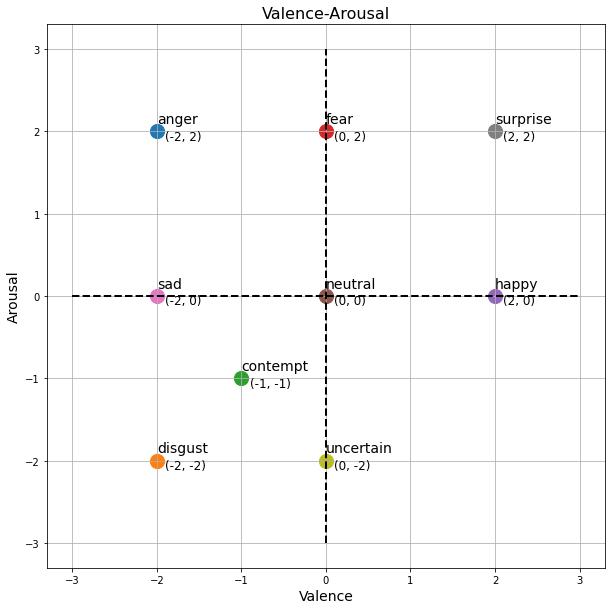

In [ ]:
plt.figure(figsize=(10, 10))
for emotion in valence_arousal:
    plt.scatter(valence_arousal[emotion][0], valence_arousal[emotion][1], s=200)
    plt.text(valence_arousal[emotion][0], valence_arousal[emotion][1]+0.1, emotion, size=14)
    plt.text(valence_arousal[emotion][0]+0.1, 
             valence_arousal[emotion][1]-0.1, 
             f'({valence_arousal[emotion][0]}, {valence_arousal[emotion][1]})', 
             size=12)
plt.hlines(0, -3, 3, linestyle='dashed', lw=2)
plt.vlines(0, -3, 3, linestyle='dashed', lw=2)
plt.grid()
plt.xlabel('Valence', size=14)
plt.ylabel('Arousal', size=14)
plt.title('Valence-Arousal', size=16)
plt.show()

Создал функцию, которая случайным образом определит координаты для каждого изображения в радиусе окружности = 0.5 относительно координат своего класса.

In [8]:
def coordinates (radius, emotion):
    r = np.random.uniform(low=0, high=radius)  # случайное значение радиуса 0.5
    angle = np.random.uniform(low=0, high=2*np.pi)  # случайное значение угла от 0 до 360
    # для x находим катет прилежащий (cos) к углу, для y противолежащий (sin)
    # прибавляем координаты центра класса
    x = np.round(r * np.cos(angle) + valence_arousal[emotion][0], 3)
    y = np.round(r * np.sin(angle) + valence_arousal[emotion][1], 3)
    return (x,y)

In [9]:
df['coordinates'] = df['emotion'].apply(lambda x: coordinates(0.5, x))
df['valence'] = df['coordinates'].apply(lambda x: x[0])
df['arousal'] = df['coordinates'].apply(lambda x: x[1])
del df['coordinates']

In [10]:
df['image_path'] = df['image_path'].astype('str')

In [11]:
df.head(3)

,image_name,image_path,emotion,valence,arousal
0,4895.jpg,redact/neutral/4895.jpg,neutral,-0.105,-0.075
1,5555.jpg,redact/neutral/5555.jpg,neutral,0.282,0.279
2,173.jpg,redact/neutral/173.jpg,neutral,-0.018,-0.086


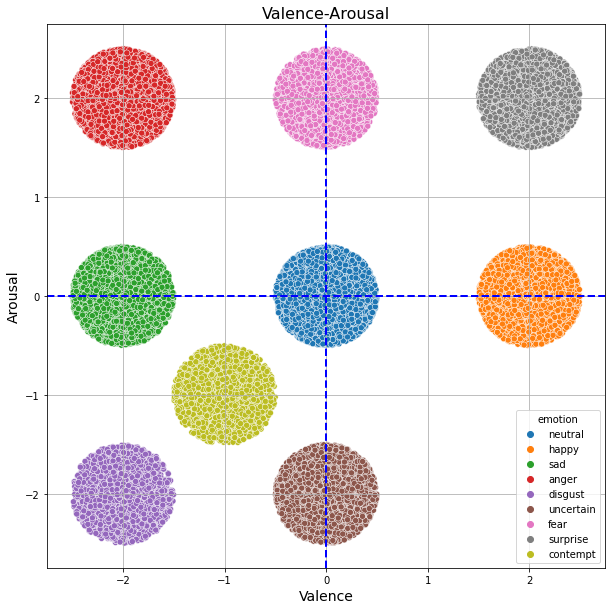

In [12]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(data=df, x='valence', y='arousal', hue='emotion')#, palette='bright', style='emotion')
plt.title('Valence-Arousal', size=16)
plt.xlabel('Valence', size=14)
plt.ylabel('Arousal', size=14)
plt.axvline(x=0, color="b", linestyle="--", lw=2)
plt.axhline(y=0, color="b", linestyle="--", lw=2)
plt.grid()
plt.show()


In [13]:
BATCH_SIZE = 128

image_gen_aug = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,  # максимальный угол поворота
    horizontal_flip=True, # случайное отражение по горизонтали
    fill_mode="nearest", # чем заполнять пробелы
    validation_split=0.2  # соотношение тренировочных/валидационных данных = 0.8/0.2
    ) 


train_data_gen = image_gen_aug.flow_from_dataframe(batch_size=BATCH_SIZE,
                                                   dataframe=df,
                                                   x_col='image_path',
                                                   y_col=['valence','arousal'],
                                                   directory=None,
                                                   shuffle=True,
                                                   target_size=(128,128),
                                                   class_mode='raw',
                                                   subset = "training",
                                                   interpolation='nearest',
                                                   validate_filenames=False)  # 80%

val_data_gen = image_gen_aug.flow_from_dataframe(batch_size=BATCH_SIZE,
                                                 dataframe=df,
                                                 x_col='image_path',
                                                 y_col=['valence','arousal'],
                                                 directory=None,
                                                 shuffle=False,
                                                 target_size=(128,128),
                                                 class_mode='raw',
                                                 subset = "validation",
                                                 interpolation='nearest',
                                                 validate_filenames=False)  # 20%


Found 38567 non-validated image filenames.
Found 9641 non-validated image filenames.


#VGG19

In [ ]:
!pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback

In [15]:
all_base_model = tf.keras.applications.VGG19(input_shape=(128, 128, 3),
                                             include_top=False,
                                             weights='imagenet')
all_base_model.trainable = True # размораживаем всю базовую модель

80150528/80134624 [==============================] - 1s 0us/step


In [20]:
model_all = tf.keras.Sequential([
    all_base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(2, activation='linear')
])

model_all.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
                  loss='mse',
                  metrics=['mae'])

model_all.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 20,025,410
Trainable params: 20,025,410
Non-trainable params: 0
_________________________________________________________________


In [21]:
output_weights = Path("/content/drive/My Drive/weights_valence_arousal")
output_weights.mkdir(exist_ok=True)
file_name_weights = 'weights_VA.h5'
cpt_path_weights = str(output_weights / file_name_weights)

In [22]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    cpt_path_weights,
    monitor='val_mae',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='min'
)

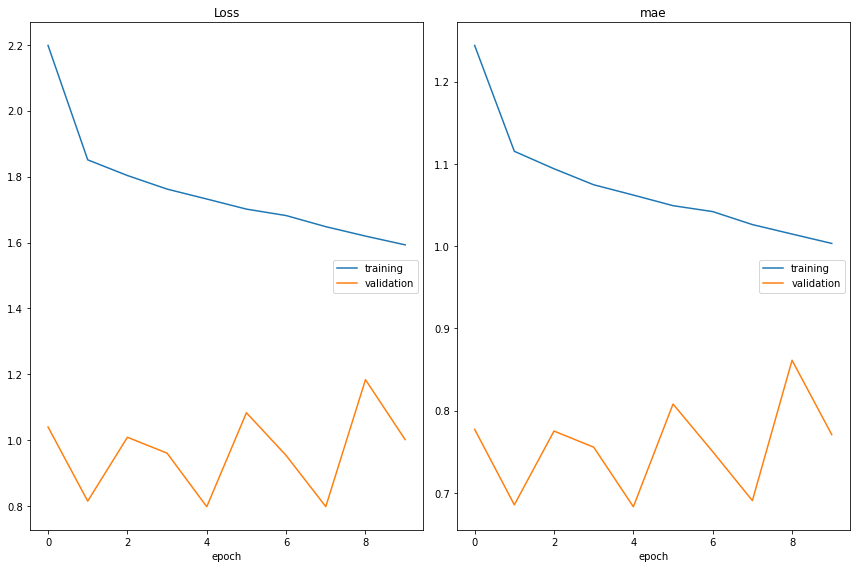

Loss
	training         	 (min:    1.593, max:    2.198, cur:    1.593)
	validation       	 (min:    0.798, max:    1.184, cur:    1.002)
mae
	training         	 (min:    1.003, max:    1.244, cur:    1.003)
	validation       	 (min:    0.683, max:    0.861, cur:    0.771)

Epoch 10: val_mae did not improve from 0.68302
302/302 [==============================] - 448s 1s/step - loss: 1.5929 - mae: 1.0033 - val_loss: 1.0019 - val_mae: 0.7707


In [23]:
EPOCHS = 10
history = model_all.fit_generator(
    train_data_gen,
    epochs=EPOCHS,
    validation_data=val_data_gen,
    callbacks=[PlotLossesCallback(), checkpoint])

Загружаем лучшие веса, полученные при обучении и уменьшим скорость обучения в 10 раз.

In [24]:
model_all.load_weights(cpt_path_weights)

In [25]:
model_all.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.000001),
                  loss='mse',
                  metrics=['mae'])

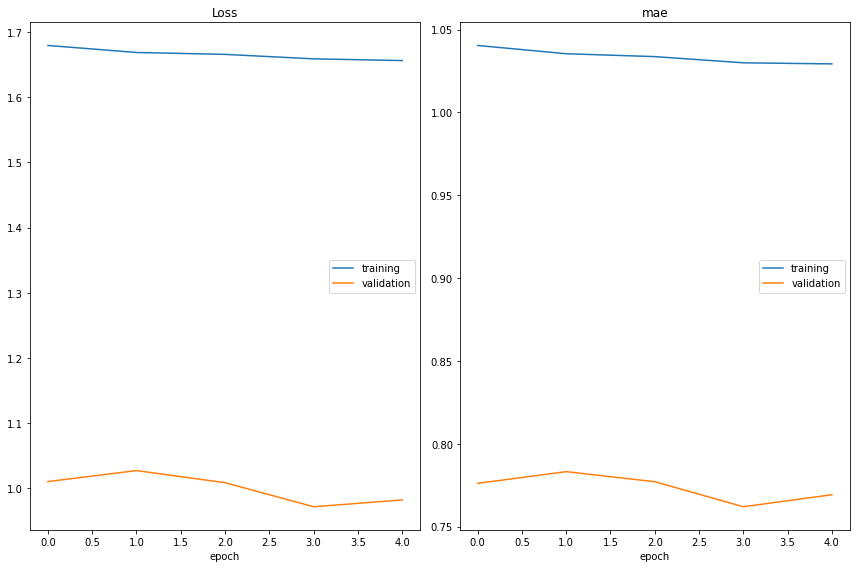

Loss
	training         	 (min:    1.656, max:    1.679, cur:    1.656)
	validation       	 (min:    0.972, max:    1.027, cur:    0.982)
mae
	training         	 (min:    1.029, max:    1.040, cur:    1.029)
	validation       	 (min:    0.762, max:    0.783, cur:    0.769)

Epoch 5: val_mae did not improve from 0.68302
302/302 [==============================] - 441s 1s/step - loss: 1.6563 - mae: 1.0293 - val_loss: 0.9822 - val_mae: 0.7692


In [26]:
EPOCHS = 5
history = model_all.fit_generator(
    train_data_gen,
    epochs=EPOCHS,
    validation_data=val_data_gen,
    callbacks=[PlotLossesCallback(), checkpoint])

In [27]:
model_all.load_weights(cpt_path_weights)

Сохраняем модель

In [28]:
model_all.save('/content/drive/MyDrive/DS_identity_emotions/model_VA/valence_arousal')

Посмотрим на прогноз модели, а расцветку оставим исходной.

In [29]:
emotion_list = []
valence_list = []
arousal_list = []
emotion_pred_list = []
for i in range((9641 // 128) - 2):
    sample_images, sample_labels = next(val_data_gen)
    for label_idx in range(128):
        distances = np.linalg.norm(np.array(list(valence_arousal.values())) - sample_labels[label_idx], axis=1)
        name_emotion = list(valence_arousal.keys())[np.argmin(distances)]
        predict = model_all.predict(sample_images[label_idx][None,...])
        distances_pred = np.linalg.norm(np.array(list(valence_arousal.values())) - predict, axis=1)
        name_emotion_predict = list(valence_arousal.keys())[np.argmin(distances_pred)]
        emotion_list.append(name_emotion)
        valence_list.append(predict[0][0])
        arousal_list.append(predict[0][1])
        emotion_pred_list.append(name_emotion_predict)


In [30]:
df_pred = pd.DataFrame()
df_pred['emotion'] = emotion_list
df_pred['valence'] = valence_list
df_pred['arousal'] = arousal_list
df_pred['emotion_pred'] = emotion_pred_list
df_pred['accuracy'] = df_pred['emotion'] == df_pred['emotion_pred']
print('Точность определения на валидационных данных составляет:', round(df_pred['accuracy'].sum() / df_pred.shape[0] * 100, 1), '%')

Точность определения на валидационных данных составляет: 51.8 %


In [32]:
for i in range((38567 // 128) - 2):
    sample_images, sample_labels = next(train_data_gen)
    for label_idx in range(128):
        distances = np.linalg.norm(np.array(list(valence_arousal.values())) - sample_labels[label_idx], axis=1)
        name_emotion = list(valence_arousal.keys())[np.argmin(distances)]
        predict = model_all.predict(sample_images[label_idx][None,...])
        distances_pred = np.linalg.norm(np.array(list(valence_arousal.values())) - predict, axis=1)
        name_emotion_predict = list(valence_arousal.keys())[np.argmin(distances_pred)]
        emotion_list.append(name_emotion)
        valence_list.append(predict[0][0])
        arousal_list.append(predict[0][1])
        emotion_pred_list.append(name_emotion_predict)

In [33]:
df_pred = pd.DataFrame()
df_pred['emotion'] = emotion_list
df_pred['valence'] = valence_list
df_pred['arousal'] = arousal_list
df_pred['emotion_pred'] = emotion_pred_list
df_pred['accuracy'] = df_pred['emotion'] == df_pred['emotion_pred']
print('Точность определения на всем наборе данных составляет:', round(df_pred['accuracy'].sum() / df_pred.shape[0] * 100, 1), '%')

Точность определения на всем наборе данных составляет: 30.8 %


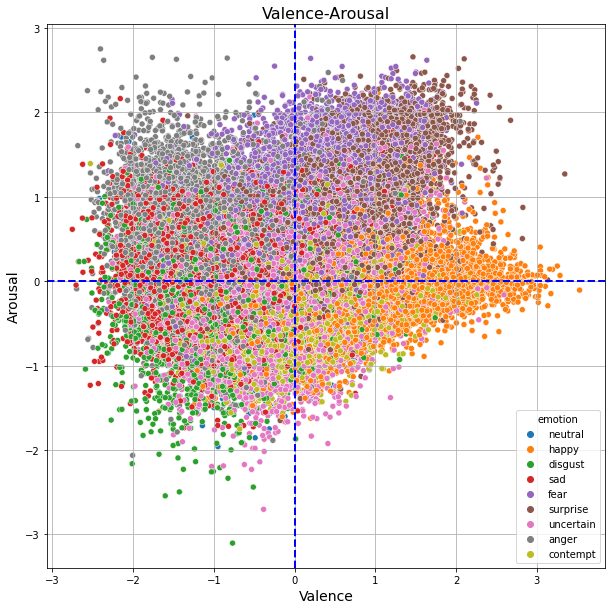

In [34]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(data=df_pred, x='valence', y='arousal', hue='emotion')
plt.title('Valence-Arousal', size=16)
plt.xlabel('Valence', size=14)
plt.ylabel('Arousal', size=14)
plt.axvline(x=0, color="b", linestyle="--", lw=2)
plt.axhline(y=0, color="b", linestyle="--", lw=2)
plt.grid()
plt.show()

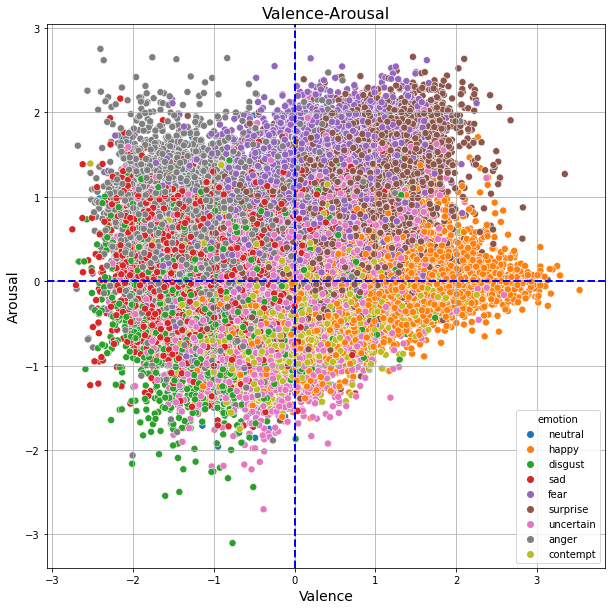

In [46]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(data=df_pred, x='valence', y='arousal', hue='emotion', s=50)
plt.title('Valence-Arousal', size=16)
plt.xlabel('Valence', size=14)
plt.ylabel('Arousal', size=14)
plt.axvline(x=0, color="b", linestyle="--", lw=2)
plt.axhline(y=0, color="b", linestyle="--", lw=2)
plt.grid()
plt.show()

# Загрузка детектора MT-CNN и создание класса модели

In [35]:
!pip install mtcnn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 15.4 MB/s 


In [36]:
from mtcnn import MTCNN

In [37]:
class ValenceArousalModel:
    """Класс ValenceArousalModel используется для разложения эмоций 
    в координатах Valence-Arousal
    Используется детектор MT-CNN
    
    Attributes
    ----------
    config : str
        полный путь до модели

    Methods
    -------
    predict(image)
        Принимает на вход изображение и возвращает эмоцию
    detect_face(image)
        На вход изображение и возвращает: 
        1) Маркер True - если есть лицо, False - если нет.
        2) Изображение обрезанное по bounding box (остается только лицо).
    """
    def __init__(self, config:str):
        self.config = config  # путь к модели (формат строка)
        self.model = tf.keras.models.load_model(self.config)  # загружаем модель
        self.detector = MTCNN()  # инициализируем детектор

    def preprocess_image(self, img):
        img = cv2.resize(img, (128,128), interpolation=cv2.INTER_AREA)  # размер 128*128 для входа в сеть
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # преобразуем в формат RGB
        img = preprocess_input(img)  # препроцессинг для VGG19
        return img
    
    def detect_face(self, image):
        detect = self.detector.detect_faces(image)
        total_idx = 0  # индекс box
        if len(detect) == 0:  # если box - не найден, отправим маркер False
            return False, image
        else:
            total_idx = 0
            if len(detect) > 1:
                # если несколько лиц на изображении, выбираем box с наибольшей площадью - как основу
                total_square = detect[total_idx]['box'][2] * detect[total_idx]['box'][3]
                for idx_box in range(1, len(detect)):
                    square_box = detect[idx_box]['box'][2] * detect[idx_box]['box'][3]
                    if square_box > total_square:
                        total_idx = idx_box
                        total_square = square_box
            # если один box, его индекс остается равным 0
            x_img, y_img, width_img, height_img = detect[total_idx]['box']
            # вырезаем изображение по границам box
            img_new = image[y_img:y_img+height_img, x_img:x_img+width_img, :]
            return True, img_new

    def predict(self, image):
        valence_arousal = {
            'anger':    [-2, 2],
            'disgust':  [-2,-2],
            'contempt': [-1,-1],
            'fear':     [ 0, 2],
            'happy':    [ 2, 0],
            'neutral':  [ 0, 0],
            'sad':      [-2, 0],
            'surprise': [ 2, 2],
            'uncertain':[ 0,-2]
            }
        _, img_face = self.detect_face(image)
        img_inp = self.preprocess_image(img_face)
        if _:
            predict = self.model.predict(img_inp[None,...])  # получаем координаты точки
            distances_pred = np.linalg.norm(np.array(list(valence_arousal.values())) - predict, axis=1)
            name_emotion = list(valence_arousal.keys())[np.argmin(distances_pred)]
            return name_emotion
        else:
            return 'neutral'  # если лица нет на изображении - оставим "нейтральную" эмоцию


In [38]:
model = ValenceArousalModel('/content/drive/MyDrive/DS_identity_emotions/model_VA/valence_arousal')

#Загрузка тестовых данных

In [39]:
# прописываем путь к архиву
zip_file = '/content/drive/MyDrive/DS_identity_emotions/input_data/test_kaggle.zip'

# распакуем архив
z = zipfile.ZipFile(zip_file, 'r')
z.extractall()

In [40]:
test_dir = Path().parent / "test_kaggle"
count_file = os.listdir(test_dir)  # создаем список файлов в папке

In [41]:
df_kaggle = pd.DataFrame(count_file, columns = ['image_path'])
df_kaggle['sort'] = df_kaggle['image_path'].apply(lambda x: int(x[:-4]))  # создадим колонку sort для сортировки изображений
df_kaggle.sort_values(['sort'], ascending=True, inplace=True)
df_kaggle.index = df_kaggle['sort'].values
del df_kaggle['sort']

#Создаем файл .csv с прогнозом модели

In [42]:
df_kaggle['emotion'] = df_kaggle['image_path'].apply(lambda x: model.predict(cv2.imread("./test_kaggle/" + x)))

In [43]:
df_kaggle.set_index('image_path', inplace=True)
df_kaggle.to_csv("submission.csv")

In [44]:
df_kaggle.head(5)

,emotion
image_path,
0.jpg,sad
1.jpg,neutral
2.jpg,fear
3.jpg,neutral
4.jpg,contempt


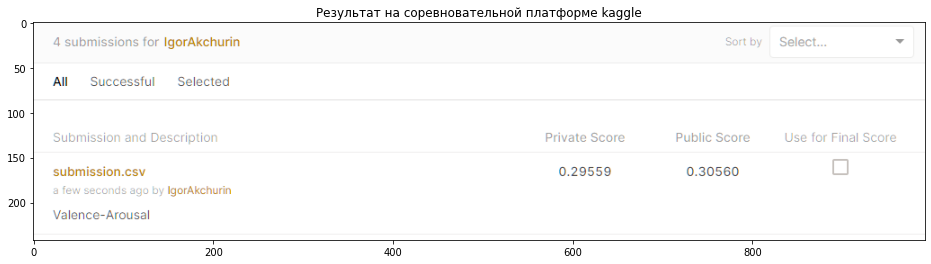

In [5]:
img_out = cv2.imread("/content/drive/MyDrive/Diplom/Out_kaggle_VA.png")
fig, ax = plt.subplots(figsize=(16, 4))
ax.imshow(img_out)
plt.title('Результат на соревновательной платформе kaggle')
plt.show()

#Результат на соревновательной платформе kaggle:</br>
Public Score – **0.30560**</br>
Private Score – **0.29559**</br>
</br></br>
Данная модель даже прошла отметку "зачет" > 0.29880.</br> Но для оценки "хорошо" уже не подходит, т.к. на Privat Score 0.29559 < 0.29880.</br></br>
Для проведенного эксперимента с valence-arousal разложением эмоций этого вполне достаточно, т.к. это не основная модель.